In [1]:
# General
import os
import numpy as np
import sys
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#ML
import tensorflow as tf
from tensorflow.keras import mixed_precision, layers
mixed_precision.set_global_policy("mixed_float16")
AUTO = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
Params = {
    "batch_size": 128
}

In [23]:
def load_dataset(files, window=True):
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads = AUTO)
    
    def _parse_function(example_proto):
        keys_to_feature = {}
        keys_to_feature["TimeSeries"] = tf.io.FixedLenFeature([4096,1], tf.float32)
        keys_to_feature["GroundTruths"] = tf.io.FixedLenFeature([4096,1], tf.float32)
        
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        return parsed_features["TimeSeries"], parsed_features["GroundTruths"]
    
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.batch(Params["batch_size"])
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [24]:
data_files = glob("../input/synthetic-tfrec/*.tfrec")
train_files = data_files[:-2]
val_files = data_files[-2:]

In [25]:
train_ds = load_dataset(train_files)
val_ds = load_dataset(val_files)
train_ds

<PrefetchDataset shapes: ((None, 4096, 1), (None, 4096, 1)), types: (tf.float32, tf.float32)>

In [26]:
def ownInitializer(shape, dtype=None):
    return tf.constant([
        [[1,0,0,0]],
        [[0,1,0,0]],
        [[0,0,1,0]],
        [[0,0,0,1]]
    ],dtype=dtype)

ownInitializer(2,tf.float32)

<tf.Tensor: shape=(4, 1, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.]],

       [[0., 1., 0., 0.]],

       [[0., 0., 1., 0.]],

       [[0., 0., 0., 1.]]], dtype=float32)>

In [27]:
model = tf.keras.Sequential([
    layers.Conv1D(kernel_size=4, filters=4,
                       kernel_initializer=ownInitializer, input_shape=[4096,1], trainable=False),
    layers.ZeroPadding1D(padding=[0,3]),
    layers.Reshape([4096,4,1]),
    layers.TimeDistributed(layers.Conv1D(kernel_size=32, filters=32, activation="tanh", padding="same")),
    layers.TimeDistributed(layers.MaxPool1D()),
    layers.TimeDistributed(layers.Conv1D(kernel_size=16, filters=16, activation="tanh", padding="same")),
    layers.TimeDistributed(layers.Flatten()),
    
#     layers.Reshape([4093,32]),
    
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    
    
#     layers.Bidirectional(layers.LSTM(400)),
    
    
    layers.TimeDistributed(layers.Dense(1, activation="sigmoid", dtype=tf.float32))
])
model.compile(
    optimizer="Adam",
    metrics="cosine_similarity",
    loss="mean_squared_error"
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4093, 4)           20        
_________________________________________________________________
zero_padding1d (ZeroPadding1 (None, 4096, 4)           0         
_________________________________________________________________
reshape (Reshape)            (None, 4096, 4, 1)        0         
_________________________________________________________________
time_distributed (TimeDistri (None, 4096, 4, 32)       1056      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4096, 2, 32)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4096, 2, 16)       8208      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4096, 32)          0

In [31]:
train_steps = len(train_files) * 12500 // Params["batch_size"]
val_steps = len(val_files) * 12500 // Params["batch_size"]

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=5, min_lr = 0.000001,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.0003,
    mode="min",
    patience=10
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     f"{MDL_PATH}/model_{Params['version']:03}.h5",
    "./model.h5"
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weight_only=False,
    mode="auto",
    save_freq="epoch"
)

callbacks=[get_lr_callback(Params["batch_size"]) ,reduce_lr, early_stop, model_checkpoint]

In [32]:
model.fit(train_ds,validation_data=val_ds, validation_steps=val_steps, steps_per_epoch=train_steps,
          epochs=2)

Epoch 1/2
585/585 [==============================] - 1093s 2s/step - loss: 0.0023 - cosine_similarity: -1.3021e-04 - val_loss: 4.7634e-04 - val_cosine_similarity: 1.3622e-04
Epoch 2/2
585/585 [==============================] - 924s 2s/step - loss: 4.7172e-04 - cosine_similarity: -1.2819e-04 - val_loss: 4.7634e-04 - val_cosine_similarity: 1.3622e-04


In [34]:
predictions = model.predict(train_ds, steps=50)

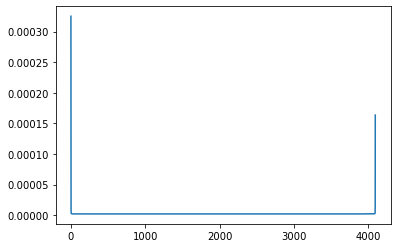

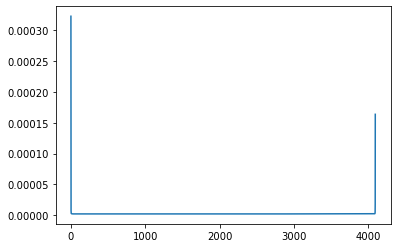

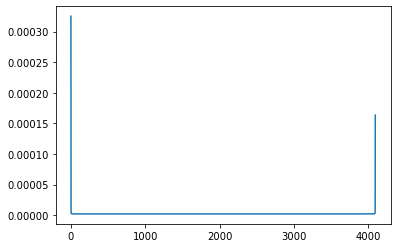

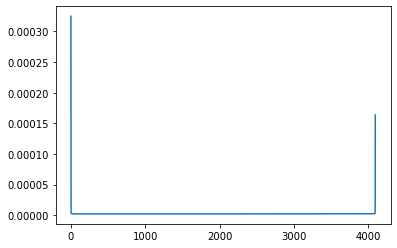

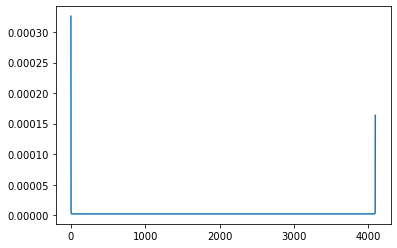

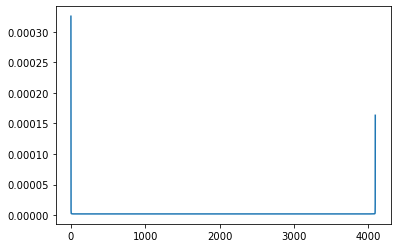

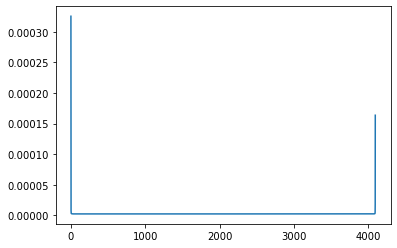

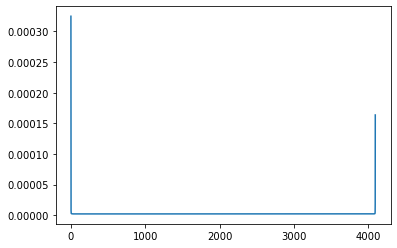

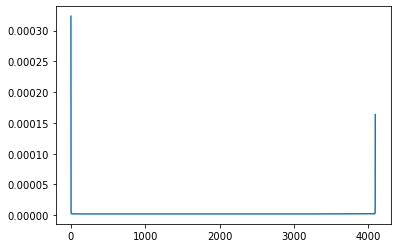

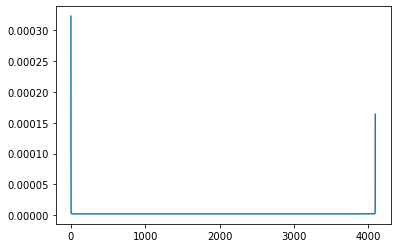

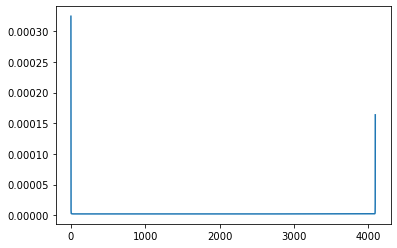

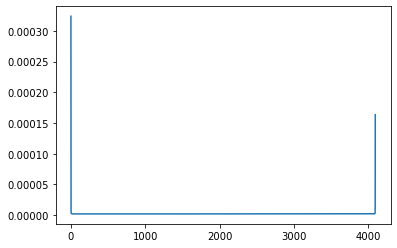

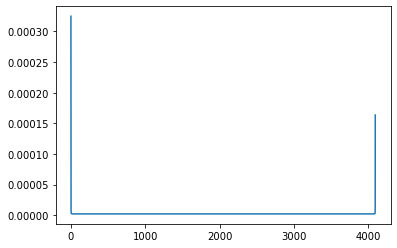

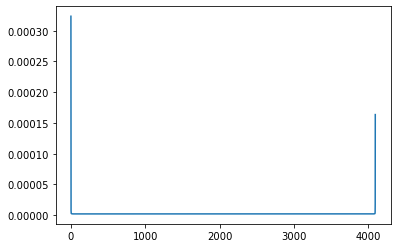

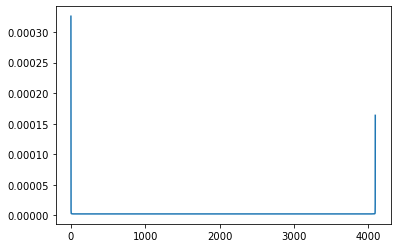

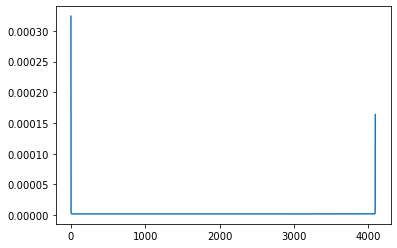

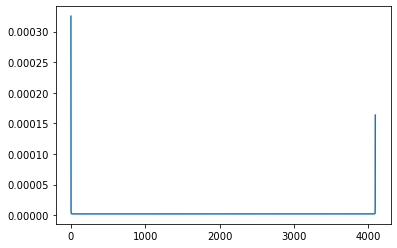

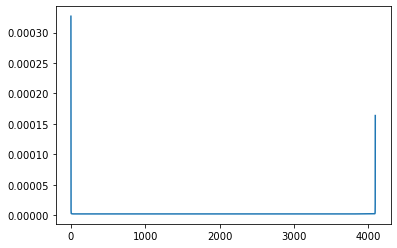

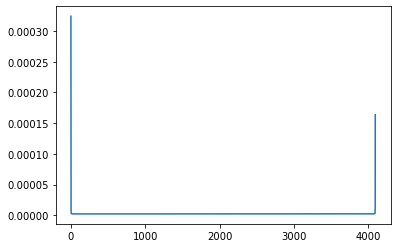

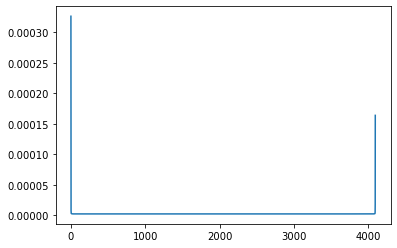

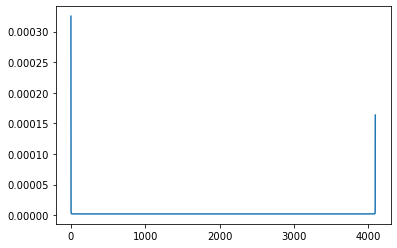

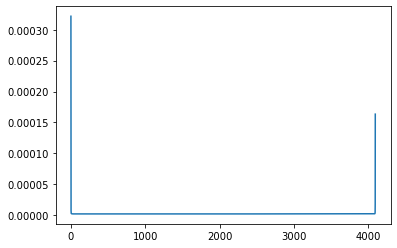

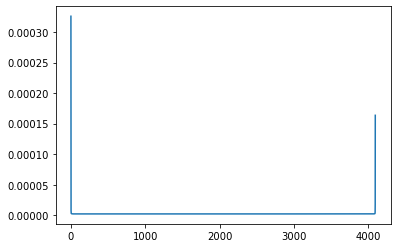

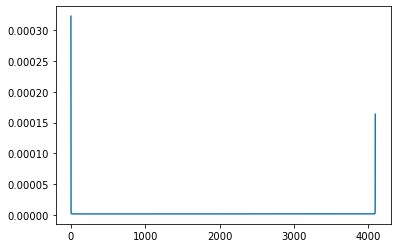

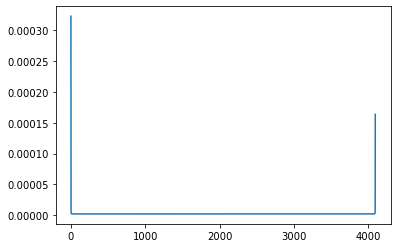

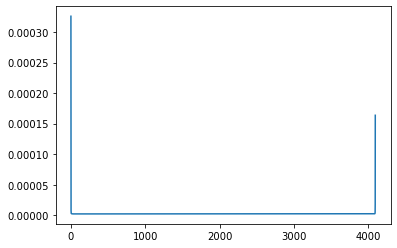

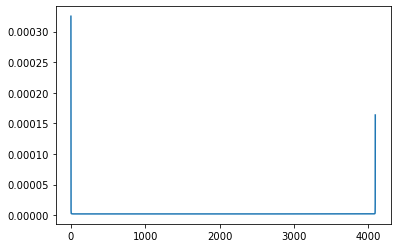

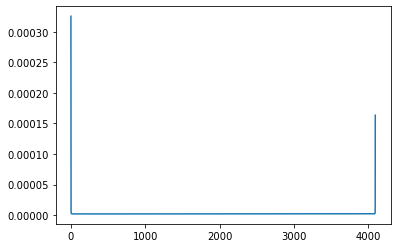

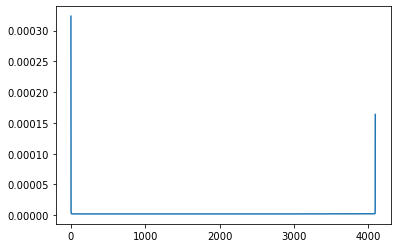

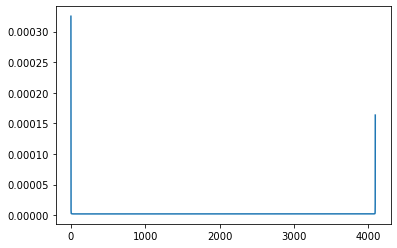

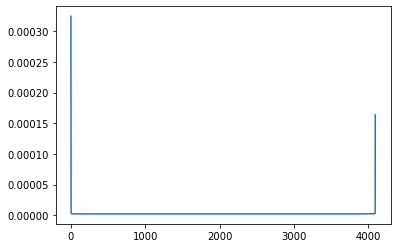

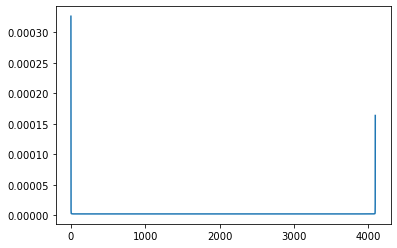

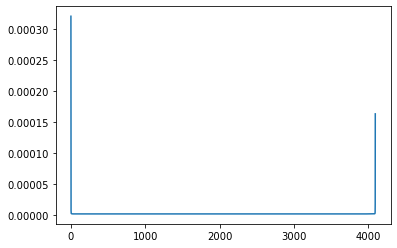

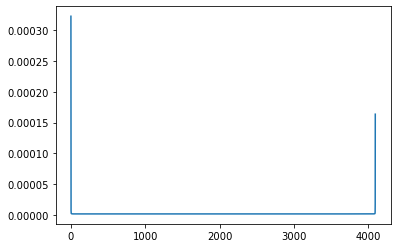

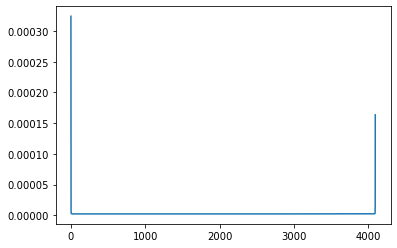

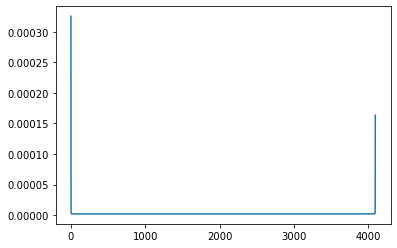

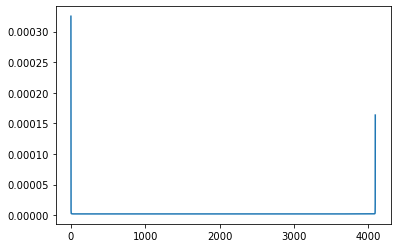

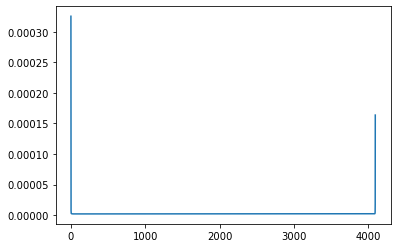

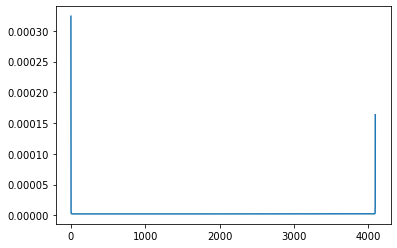

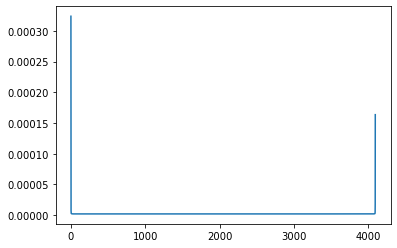

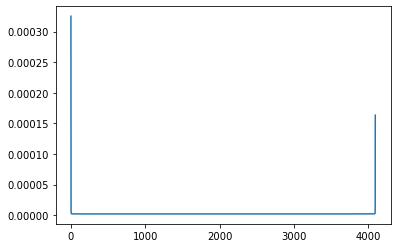

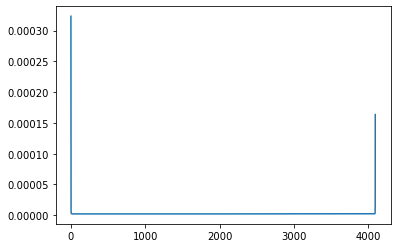

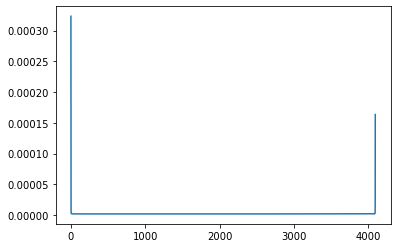

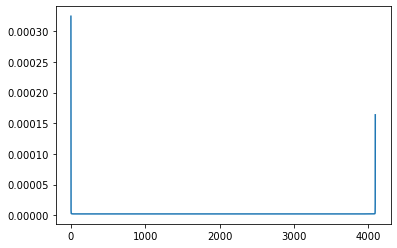

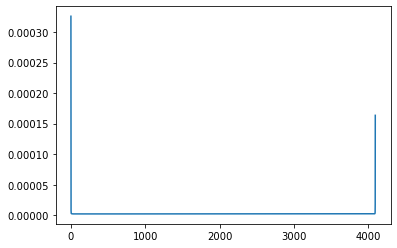

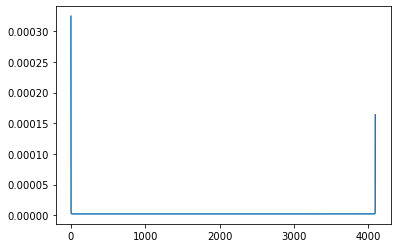

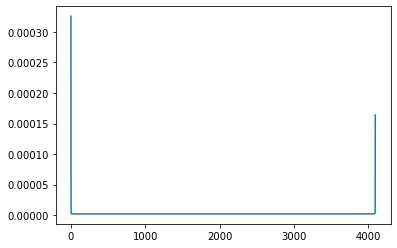

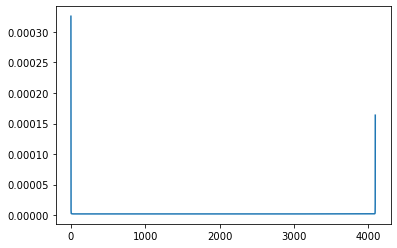

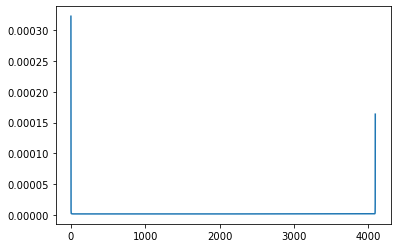

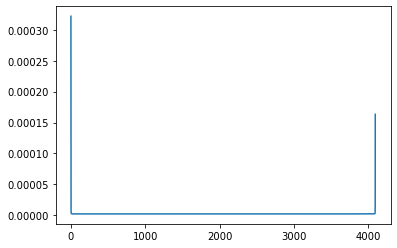

In [35]:
import matplotlib.pyplot as plt
for i in range(50):
    
    plt.plot(predictions[i])
    plt.show()

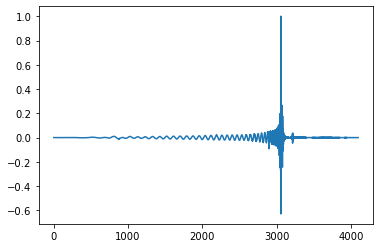

In [64]:
for i in train_ds:
    plt.plot(i[1][14])
    j+=1
    break
    